This notebook demonstrates the implementation of transfer learning using pre-trained models (ResNet18, AlexNet, and DenseNet121) on the CIFAR-10 dataset. 
Transfer learning allows us to leverage knowledge from previously trained models on large datasets (like ImageNet for example) to improve performance for our specific datasets.

We begin by importing necessary libraries and setting up our data processing pipeline

In [ ]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models
import matplotlib.pyplot as plt
import tempfile
from tabulate import tabulate
import torch

# Initial Setup and Data Loading

In the next rows, we will declare some functions to will help us with the transfer learning process. We will try to keep isolated each functionality so it makes easier to use it and explain later in the code. Specifically, we will declare functions for:
1. download the CIFAR-10 dataset. We will make use of `Dataloaders` to load the data in batches. We have worked with `Dataloaders` in the previous notebooks, this is a class that manage a dataset by creating an iterable dataset object, it provides batches which will be fed into the model.
2. Get the device to run the model on (Help us to make the code device agnostic)
3. Visualize images from the dataset



In [ ]:
# Download CIFAR-10 dataset and create data loaders
def get_cifar10_loaders(num_train=45000, batch_size=64, data_path=None):
    """
    Creates and returns DataLoaders for CIFAR-10 dataset with proper transformations
    for transfer learning.

    Args:
        num_train (int): Number of training samples (default: 45000)
        batch_size (int): Size of mini-batches (default: 64)
        data_path (str): Path to store/load dataset. If None, uses temp directory

    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    # Use temporary directory if no path specified
    if data_path is None:
        import tempfile
        data_path = tempfile.gettempdir()

    # Define transformations for transfer learning with ImageNet models
    transform_imagenet = T.Compose([
        T.Resize(224),                # Resize images to ImageNet size
        T.ToTensor(),                 # Convert to tensor (0-1 range)
        # ImageNet normalization values
        # We use these specific values to ensure our input images are normalized 
        # in the same way as the images that were used to train
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Load training dataset and create train/val split
    cifar10_train = datasets.CIFAR10(data_path,
                                    train=True,
                                    download=True,
                                    transform=transform_imagenet)

    # Create training loader with subset sampler
    train_loader = DataLoader(
        cifar10_train,
        batch_size=batch_size,
        sampler=sampler.SubsetRandomSampler(range(num_train))
    )

    # Create validation loader with remaining training data
    val_loader = DataLoader(
        cifar10_train,
        batch_size=batch_size,
        sampler=sampler.SubsetRandomSampler(range(num_train, len(cifar10_train)))
    )

    # Load and create test loader
    cifar10_test = datasets.CIFAR10(data_path,
                                   train=False,
                                   download=True,
                                   transform=transform_imagenet)
    test_loader = DataLoader(cifar10_test, batch_size=batch_size)

    return train_loader, val_loader, test_loader

# 2. Get the device to run the model on (Help us to make the code device agnostic)
def get_device(force_cpu=False):
    """
    Returns the best available device for PyTorch operations.

    Args:
        force_cpu (bool): If True, will return CPU even if CUDA is available
                         Useful for debugging or when GPU memory is limited

    Returns:
        torch.device: 'cuda' if GPU is available (and force_cpu=False), 'cpu' otherwise
    """
    if not force_cpu and torch.cuda.is_available():
        device = torch.device('cuda')
        print(f'Using CUDA device: {torch.cuda.get_device_name(0)}')
    else:
        device = torch.device('cpu')
        print('Using CPU')

    return device

# 3. Visualize images from the dataset
def plot_random_sample(loader, classes=None):
    """
    Randomly selects and plots an image from a DataLoader with its corresponding label.

    Args:
        loader (DataLoader): PyTorch DataLoader containing the dataset
        classes (list, optional): List of class names. If None, will only show class index

    Returns:
        tuple: (image_tensor, label) of the plotted sample
    """
    # Get a random index
    rnd_sample_idx = np.random.randint(len(loader.dataset))

    # Get the image and label
    image, label = loader.dataset[rnd_sample_idx]

    # Normalize image for visualization
    image_normalized = (image - image.min()) / (image.max() - image.min())

    # Print the class
    if classes:
        print(f'This image represents: {classes[label]}')
    else:
        print(f'Class index: {label}')

    # Plot the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image_normalized.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

    return image, label

Let's proceed to download and examine our data

100%|██████████| 170M/170M [00:21<00:00, 8.06MB/s]


Extracting /tmp/cifar-10-python.tar.gz to /tmp
Files already downloaded and verified
Using CUDA device: Tesla T4

Viewing random samples from training data:
This image represents: Frog


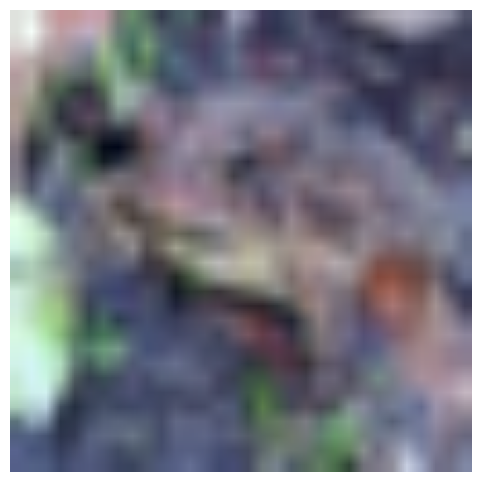

In [ ]:
# Get the DataLoaders for training, validation and test
train_loader, val_loader, test_loader = get_cifar10_loaders()
# Get the device to run the model on
device = get_device()
# Define CIFAR-10 classes for better visualization
cifar10_classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer',
                   'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Visualize some random samples from training data
print("\nViewing random samples from training data:")
for _ in range(1):  # Show 1 random samples
    plot_random_sample(train_loader, cifar10_classes)

# Downloads Pretrained Models
We will use three different architectures:
- ResNet18
- AlexNet
- DenseNet121

In the next rows we will declare functions that will help us to:
1. Download pretrained models from PyTorch Hub
2. Explore the model architecture (we are interesting in the last layer as we will replace it with our own classifier)

In [ ]:
def get_pretrained_model(model_name='resnet18'):
    """
    Get a pretrained model from PyTorch's model zoo without modifying its architecture.

    Args:
        model_name (str): Name of the pretrained model to load
            Options: 'resnet18', 'alexnet', 'vgg16', 'densenet121'

    Returns:
        model: Original pretrained PyTorch model (1000 ImageNet classes)
    """
    # Dictionary of supported models and their constructors
    models_dict = {
        'resnet18': models.resnet18,
        'alexnet': models.alexnet,
        'vgg16': models.vgg16,
        'densenet121': models.densenet121
    }

    # Check if requested model is supported
    if model_name not in models_dict:
        raise ValueError(f"Model {model_name} not supported. Choose from: {list(models_dict.keys())}")

    # Load pretrained model, log action to the console
    print(f"Loading pretrained {model_name}...")
    model = models_dict[model_name](pretrained=True)

    return model

In [ ]:
def model_to_table_summary(model):
    """
    Creates a minimal table showing only the last layer of the model.

    Args:
        model (nn.Module): PyTorch model to convert

    Returns:
        str: Formatted table showing last layer
    """
    table_data = []

    def get_last_layer(model):
        """Helper function to get the last linear layer based on model architecture"""
        if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Linear):  # DenseNet
            return model.classifier
        elif hasattr(model, 'classifier'):  # AlexNet, VGG
            return model.classifier[-1]
        elif hasattr(model, 'fc'):        # ResNet
            return model.fc
        raise ValueError("Could not find last layer")

    # Get last layer
    try:
        last_layer = get_last_layer(model)
        table_data.append([
            last_layer.__class__.__name__,
            f"{last_layer.in_features} → {last_layer.out_features}"
        ])
    except Exception as e:
        print(f"Warning: Could not process last layer: {e}")

    headers = ["Type", "Features (in → out)"]
    return tabulate(table_data, headers=headers, tablefmt="grid")



Now, let's download the models and visualize the last layer of the models

In [ ]:
# download the pretrained models
resnet_model = get_pretrained_model(model_name="resnet18")
alexnet_model = get_pretrained_model(model_name="alexnet")
densenet_model = get_pretrained_model(model_name="densenet121")

Loading pretrained resnet18...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

Loading pretrained alexnet...


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 151MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


Loading pretrained densenet121...


100%|██████████| 30.8M/30.8M [00:00<00:00, 175MB/s]


In [ ]:
# let's visualize the last layer of the models
print(f"ResNet18:\n{model_to_table_summary(resnet_model)}")
print(f"\nAlexNet:\n{model_to_table_summary(alexnet_model)}")
print(f"\nDenseNet:\n{model_to_table_summary(densenet_model)}")

ResNet18:
+--------+-----------------------+
| Type   | Features (in → out)   |
+========+=======================+
| Linear | 512 → 1000            |
+--------+-----------------------+

AlexNet:
+--------+-----------------------+
| Type   | Features (in → out)   |
+========+=======================+
| Linear | 4096 → 1000           |
+--------+-----------------------+

DenseNet:
+--------+-----------------------+
| Type   | Features (in → out)   |
+========+=======================+
| Linear | 1024 → 1000           |
+--------+-----------------------+


# Transfer learning processes

Transfer learning is a powerful technique that allows us to leverage pre-trained models. And its relatively straight forward. The main steps are:

1. Remove the final classification layer
2. Freeze all the parameters
2. Add a new classifier layer for our 10 classes
3. Train the new classifier layer.
3. Unfreeze the parameters previously frozen
4. Train again for a few epochs

The last 2 steps are part of the fine tuning process.

Of course these steps outline a basic process, and there are some details that could make it more complex.
For example, during the realization of this exercise we had some troubles connecting the last layer to the new classifier. Restnet has an AdaptiveAvgPool2d layer before the final linear layer, this layer reduces any input size to a fixed 512-dimensional feature vector, but alexnet and densenet don't have this adaptive pooling behavior, AlexNet produces 9216 features and DenseNet produces features of size 50176. We needed to adapt a function to manage such differences.

Another interesting challenge, was to examine the composition of the models, debugging the freeze and unfreeze parameters, and making sure the final configuration of the model was correct.

After multiple variations of the exercise, we have delimited the steps of the process into functions that we will proceed to declare. We hope that, by maintining each step in a function, the readability of this notebook will be improved.

We will declare the following functions:
1. model_to_sequential: This one will remove the last layer of the pre-trained model and return the rest of the model as a sequential container.
2. freeze_parameters
3. unfreeze_parameters
4. create_classifier: This function will be responsible to adapt the last layer of our model to a classifier with 10 classes. It's going to take into account the different dimensions of the last layer for each model.




In [ ]:
def model_to_sequential(model):
    """
    Converts a model to a Sequential container, excluding the last layer.

    Args:
        model (nn.Module): Input model (ResNet, AlexNet, DenseNet, etc.)

    Returns:
        nn.Sequential: Sequential container with all layers except the last one
    """
    # Get all layers except the last one
    layers = list(model.children())[:-1]

    # Create a Sequential container with these layers
    sequential = nn.Sequential(*layers)
    return sequential

def freeze_parameters(model):
    """
    Freezes all parameters in a model by setting requires_grad=False.

    Args:
        model (nn.Module): PyTorch model whose parameters should be frozen

    Returns:
        nn.Module: Model with frozen parameters
    """
    for param in model.parameters():
        param.requires_grad = False

    return model

def unfreeze_parameters(model):
    """
    Unfreezes all parameters in a model by setting requires_grad=True.

    Args:
        model (nn.Module): PyTorch model whose parameters should be unfrozen

    Returns:
        nn.Module: Model with unfrozen parameters
    """
    for param in model.parameters():
        param.requires_grad = True

    return model

def create_classifier(base_model, model_type, num_classes=10):
    """
    Creates a classifier by adding Flatten and Linear layers to a base model.

    Args:
        base_model (nn.Module): Base model without final classification layer
        model_type (str): Type of the original model ('ResNet', 'AlexNet', or 'DenseNet')
        num_classes (int): Number of output classes (default: 10 for CIFAR-10)

    Returns:
        nn.Sequential: New model with Flatten and appropriate Linear layer
    """
    # Dictionary mapping model types to their feature dimensions
    feature_dimensions = {
        'ResNet': 512,
        'AlexNet': 9216,
        'DenseNet': 50176
    }

    # Get input features based on model type
    for name, dim in feature_dimensions.items():
        if name in model_type:
            in_features = dim
            break
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Create new Sequential model with Flatten and Linear layers
    classifier = nn.Sequential(
        base_model,
        nn.Flatten(),
        nn.Linear(in_features=in_features, out_features=num_classes, bias=True)
    )

    return classifier



# Training and accuracy

Next we will declare functions for training and calculation of accuracy.

In [ ]:
def accuracy(model, loader):
    """
    Calculate the accuracy of a model on a given dataset.

    Args:
        model: PyTorch model to evaluate
        loader: DataLoader containing the dataset

    Returns:
        float: Accuracy score between 0 and 1
    """
    # Initialize counters for correct predictions and total samples
    num_correct = 0
    num_total = 0

    # Set model to evaluation mode (disables dropout, batch norm adjustments, etc.)
    model.eval()
    # Ensure model is on the correct device
    model = model.to(device=device)

    # Disable gradient calculations for efficiency during evaluation
    with torch.no_grad():
        # Iterate through batches in the data loader
        for (xi, yi) in loader:
            # Move input data to the same device as model
            xi = xi.to(device=device, dtype=torch.float32)  # Move images
            yi = yi.to(device=device, dtype=torch.long)     # Move labels

            # Forward pass: get model predictions
            scores = model(xi)  # Shape: [batch_size, num_classes]

            # Get the predicted class (highest score) for each sample
            _, pred = scores.max(dim=1)  # Shape: [batch_size]

            # Count correct predictions
            num_correct += (pred == yi).sum()  # Compare predictions with true labels

            # Update total number of samples processed
            num_total += pred.size(0)  # Add batch size

        # Calculate and return accuracy as a percentage
        return float(num_correct) / num_total

def train(model, optimiser, epochs=100):
    """
    Train a PyTorch model using the specified optimizer.

    Args:
        model: PyTorch model to train
        optimiser: PyTorch optimizer for updating model parameters
        epochs (int): Number of training epochs (default: 100)

    """
    # Move model to appropriate device (GPU/CPU)
    model = model.to(device=device)

    # Training loop over epochs
    for epoch in range(epochs):
        # Inner loop over batches in training data
        for i, (xi, yi) in enumerate(train_loader):
            # Set model to training mode (enables dropout, batch norm, etc.)
            model.train()

            # Move batch data to appropriate device
            xi = xi.to(device=device, dtype=torch.float32)  # Input images
            yi = yi.to(device=device, dtype=torch.long)     # Labels

            # Forward pass: compute predictions
            scores = model(xi)

            # Compute loss
            cost = F.cross_entropy(input=scores, target=yi)

            # Backward pass and optimization
            optimiser.zero_grad()           # Clear previous gradients
            cost.backward()                 # Compute gradients
            optimiser.step()                # Update weights

        # Compute validation accuracy after each epoch
        acc = accuracy(model, val_loader)
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')


# Transfer Learning execution for AlexNet, DenseNet and ResNet

At this point we have all the elements we need to perform the transfer learning. 
- We have our Dataloaders ready with the CIFAR10 dataset
- We have our pretrained models
- And we have the functions that will help us build a transfer learning pipeline for each model.

We will proceed in the following order

```
alexnet_model 
densenet_model 
resnet_model 
```

# AlexNet

In [ ]:
# Create a sequential model and remove the last layer
alexnet_model_aux = model_to_sequential(alexnet_model)
# Freeze all the parameters
alexnet_model_aux = freeze_parameters(alexnet_model_aux)
# Connect a linear layer to create a classifier with 10 classes (matching our CIFAR10)
alexnet_model_aux = create_classifier(
    base_model=alexnet_model_aux,
    model_type='AlexNet'  # Specify the original model type
)
# Move model to appropriate device
alexnet_model_aux = alexnet_model_aux.to(device)
# Declare learning rate and optimizer
initial_lr = 5e-4
optimizer = torch.optim.Adam(
    alexnet_model_aux.parameters(),
    lr=initial_lr
)


In [ ]:
# Verify the model has the correct layer configuration
alexnet_model_aux

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=9216, out_features=10

In [ ]:
# Train only the classifier (with frozen features)
print("Training AlexNet with frozen features...")
train(alexnet_model_aux, optimizer, epochs=5)

Training AlexNet with frozen features...
Epoch: 0, costo: 0.1843952089548111, accuracy: 0.8344,
Epoch: 1, costo: 0.8712192177772522, accuracy: 0.8326,
Epoch: 2, costo: 0.9213857650756836, accuracy: 0.8354,
Epoch: 3, costo: 0.4722718894481659, accuracy: 0.8318,
Epoch: 4, costo: 0.11730790138244629, accuracy: 0.8282,


In [ ]:
# Unfreeze the model for fine-tuning
unfreeze_parameters(alexnet_model_aux)
# Continue training for a few epochs
fine_tune_lr = 1e-4  
optimizer = torch.optim.Adam(alexnet_model_aux.parameters(), lr=fine_tune_lr)

print("Fine-tuning AlexNet...")
train(alexnet_model_aux, optimizer, epochs=3)  

Fine-tuning AlexNet...
Epoch: 0, costo: 0.4243334233760834, accuracy: 0.8408,
Epoch: 1, costo: 0.01422123797237873, accuracy: 0.85,
Epoch: 2, costo: 0.10735354572534561, accuracy: 0.8598,


In [ ]:
# Evaluate final model
final_accuracy = accuracy(alexnet_model_aux, test_loader)
print(f"AlexNet Final test accuracy: {final_accuracy:.4f}")

AlexNet Final test accuracy: 0.8561


# DenseNet

In [ ]:
# Create a sequential model and remove the last layer
densenet_model_aux = model_to_sequential(densenet_model)

#  Freeze all the parameters
densenet_model_aux = freeze_parameters(densenet_model_aux)

#  Connect a linear layer to create a classifier with 10 classes (matching our CIFAR10)
densenet_model_aux = create_classifier(
    base_model=densenet_model_aux,
    model_type='DenseNet'  # Specify the original model type
)

# Move model to appropriate device
densenet_model_aux = densenet_model_aux.to(device)

# Declare learning rate and optimizer
initial_lr = 5e-4
optimizer = torch.optim.Adam(
    densenet_model_aux.parameters(),
    lr=initial_lr
)

In [ ]:
# Verify the model has the correct layer configuration
densenet_model_aux

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine

In [ ]:
# Train only the classifier (with frozen features)
print("Training DenseNet with frozen features...")
train(densenet_model_aux, optimizer, epochs=5) 

Training DenseNet with frozen features...
Epoch: 0, costo: 0.027779625728726387, accuracy: 0.8226,
Epoch: 1, costo: 1.65482497215271, accuracy: 0.828,
Epoch: 2, costo: 2.0797314643859863, accuracy: 0.8262,
Epoch: 3, costo: 0.5945157408714294, accuracy: 0.83,
Epoch: 4, costo: 1.143652319908142, accuracy: 0.8306,


In [ ]:
# Unfreeze the model for fine-tuning
unfreeze_parameters(densenet_model_aux)
# Continue training with lower learning rate
fine_tune_lr = 1e-4  # Lower learning rate for fine-tuning
optimizer = torch.optim.Adam(densenet_model_aux.parameters(), lr=fine_tune_lr)

print("Fine-tuning DenseNet...")
train(densenet_model_aux, optimizer, epochs=1)  # Few epochs of fine-tuning

Fine-tuning DenseNet...
Epoch: 0, costo: 4.490619903663173e-05, accuracy: 0.9134,


In [ ]:
# Evaluate final model
final_accuracy = accuracy(densenet_model_aux, test_loader)
print(f"DenseNet final test accuracy: {final_accuracy:.4f}")

DenseNet final test accuracy: 0.9175


# ResNet

In [ ]:
# Create a sequential model and remove the last layer
resnet_model_aux = model_to_sequential(resnet_model)

# Freeze all the parameters
resnet_model_aux = freeze_parameters(resnet_model_aux)

# Connect a linear layer to create a classifier with 10 classes (matching our CIFAR10)
resnet_model_aux = create_classifier(
    base_model=resnet_model_aux,
    model_type='ResNet'  # Specify the original model type
)

# Move model to appropriate device
resnet_model_aux = resnet_model_aux.to(device)

# Declare learning rate and optimizer
initial_lr = 5e-4
optimizer = torch.optim.Adam(
    [param for param in resnet_model_aux.parameters() if param.requires_grad],
    lr=initial_lr
)


In [ ]:
# Verify the model has the correct layer configuration
resnet_model_aux

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
# Train only the classifier (with frozen features)
print("Training ResNet with frozen features...")
train(resnet_model_aux, optimizer, epochs=5)  

Training ResNet with frozen features...
Epoch: 0, costo: 1.163353681564331, accuracy: 0.7776,
Epoch: 1, costo: 0.9750633835792542, accuracy: 0.795,
Epoch: 2, costo: 0.9395719766616821, accuracy: 0.7996,
Epoch: 3, costo: 1.2892441749572754, accuracy: 0.8046,
Epoch: 4, costo: 0.2892991900444031, accuracy: 0.8048,


In [ ]:
# Unfreeze the model for fine-tuning
unfreeze_parameters(resnet_model_aux)
# Continue training for a few epochs
fine_tune_lr = 1e-4  
optimizer = torch.optim.Adam(resnet_model_aux.parameters(), lr=fine_tune_lr)

print("Fine-tuning ResNet model...")
train(resnet_model_aux, optimizer, epochs=3)  

Fine-tuning ResNet model...
Epoch: 0, costo: 0.4037736654281616, accuracy: 0.9294,
Epoch: 1, costo: 0.7318427562713623, accuracy: 0.9294,
Epoch: 2, costo: 0.006168385501950979, accuracy: 0.9398,


In [ ]:
# Evaluate final model
final_accuracy = accuracy(resnet_model_aux, test_loader)
print(f"ResNet final test accuracy: {final_accuracy:.4f}")

ResNet final test accuracy: 0.9398


# Conclusions



**Final Test Accuracies**

| Model | Test Accuracy |
|-------|--------------|
| AlexNet | 85.61% |
| DenseNet121 | 91.75% |
| ResNet18 | 93.98% |



ResNet18 had the top performance with a 93.98% accuracy, followed closely by DenseNet121 at 91.75%, while AlexNet, achieved 85.61%. We think that the success of ResNet18 can be attributed to its skip connections, which facilitate better gradient flow during training (reducing the vanishing gradient problem), altough we need to make notice that ResNet had 3 epochs of fine-tuning while DenseNet had 1. We did this to save some time resources used, but I think we can conclude that the fine tunning process acts as an important booster on the performance of the models.
